In [2]:
import gmft

In [15]:
# Function to extract tables from PDF

from gmft.pdf_bindings import PyPDFium2Document
from gmft.auto import CroppedTable, AutoTableDetector

detector = AutoTableDetector()

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for i, page in enumerate(doc):
        print(f'Processing page {i}')
        tables += detector.extract(page)
    return tables, doc

In [16]:
import pandas as pd
from gmft.auto import AutoTableFormatter


'''
Function to merge multi-page tables

Input:
- tables: list of objects produced by gmft.detector.extract (list of CroppedTable objects)
'''
def merge_tables(tables):
    # Store dictionary of merged tables (merging and indexing based on column names)
    merged_tables = {}
    for table in tables:
        # Convert CroppedTable Object to DF
        formatter = AutoTableFormatter()
        ft = formatter.extract(table)
        df = ft.df()
        
        # Use tuple of columns as the key for the dictionary
        columns_key = tuple(df.columns)
        
        # First table of its format: Add to Dictionary
        if columns_key not in merged_tables:
            merged_tables[columns_key] = df
        
        # Merge with other tables of same format
        else:
            merged_tables[columns_key] = pd.concat([merged_tables[columns_key], df], axis=0, ignore_index=True)
    
    return list(merged_tables.values())

In [18]:
import os

directory = '../loss_runs/input'
dfs = []

# Traverse each file in loss runs input directory and extract tables
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    
    # Verify file (i.e. not a subdirectory)
    if os.path.isfile(f):
        tables, doc = ingest_pdf(f)
        merged_dataframes = merge_tables(tables)
        dfs.append(merged_dataframes)


Processing page 0


ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

In [16]:
tables, doc = ingest_pdf('loss_runs/input/Loss_Run___len stoler 8-24_page_5.pdf')

Processing page 0


In [14]:
merged_dataframes = merge_tables(tables)

print(type(merged_dataframes))  # This will output: <class 'list'>
print(len(merged_dataframes))    # This will give you the number of unique DataFrames returned
print(type(merged_dataframes[0]))  # This will output: <class 'pandas.core.frame.DataFrame'>

<class 'list'>
14
<class 'pandas.core.frame.DataFrame'>


In [15]:
merged_dataframes

[                     Coverage             Sub Coverage  \
 0                  AUTOMOBILE           AUTO LIABILITY   
 1                  AUTOMOBILE           AUTO LIABILITY   
 2                  AUTOMOBILE     AUTO PHYSICAL DAMAGE   
 3                  AUTOMOBILE     AUTO PHYSICAL DAMAGE   
 4                  AUTOMOBILE     AUTO PHYSICAL DAMAGE   
 5           GENERAL LIABILITY         GARAGE LIABILITY   
 6                        None                     None   
 7   GENERAL LIABILITY GENERAL  GARAGE LIABILITY GARAGE   
 8           LIABILITY GENERAL         LIABILITY GARAGE   
 9                   LIABILITY                LIABILITY   
 10          GENERAL LIABILITY         GARAGE LIABILITY   
 11                       None                     None   
 12                   PROPERTY                 PROPERTY   
 13                       None             Claim Count:   
 14                 AUTOMOBILE     AUTO PHYSICAL DAMAGE   
 15                 AUTOMOBILE     AUTO PHYSICAL DAMAGE 

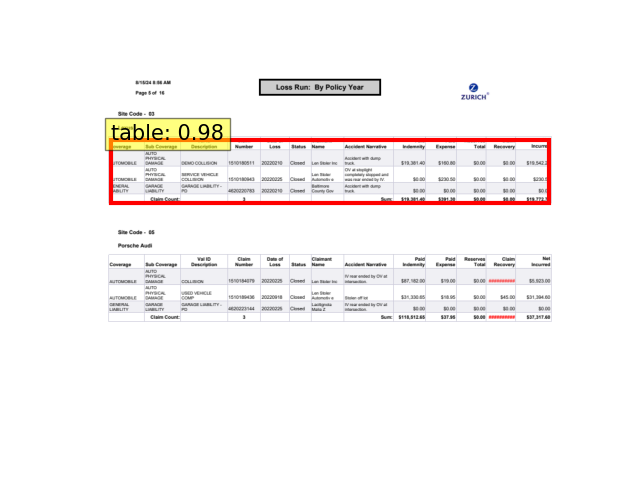

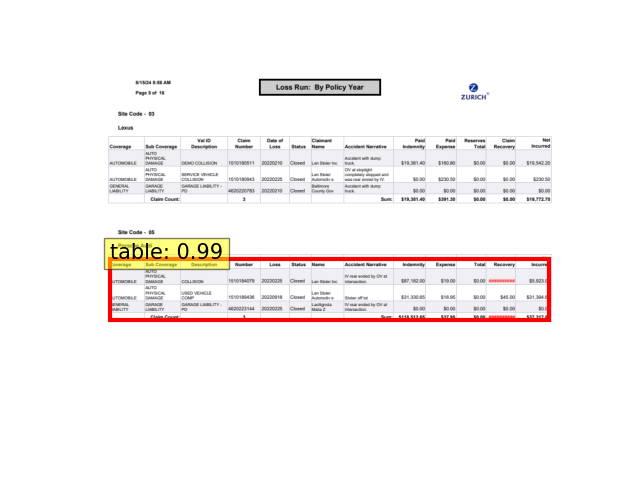

In [17]:
from IPython.display import display
# display several images
# decrease size with plt
for table in tables:
    display(table.visualize(figsize=None))


In [18]:
from gmft.auto import AutoTableFormatter
formatter = AutoTableFormatter()
ft = formatter.extract(tables[1])
ft.df()

,,,,,,,,,,,,,
0,None,None,"$31,330.65 $0.00 $118,512.65","Paid Indemnity $87,182.00",None,None,"$0.00 $0.00 $19,381.40","Paid Indemnity $19,381.40",None,None,None,None,None
1,None,None,$18.95 $0.00 $37.95,Paid Expense $19.00,None,None,$230.50 $0.00 $391.30,Paid Expense $160.80,None,None,None,None,None


# PDFPlumber

In [106]:
import pdfplumber
import pandas as pd
import numpy as np

# Specify the path to your PDF file
pdf_path = '../loss_runs/input/Copy of Stoler of Queens, Inc dba Silver Star Motors - Loss Run - 942024.pdf'

# Define a function to process each table
def process_table(table):
    df = pd.DataFrame(table[1:], columns=table[0])  # Convert table to DataFrame
    return df

# Store all tables extracted from current PDF
tables = []

# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:
    # Iterate over pages, extracting tables from each
    for page_number, page in enumerate(pdf.pages):
        print(f"Extracting tables from page {page_number + 1}")
        
        # Extract tables from the page
        for table in page.extract_tables():
            tables.append(table)

# Iterate over tables, coalescing those of the same column count into single DataFrames
dfs = {}

for table in tables:
    # Insert new DataFrame
    if len(table) > 0:
        columns = table[0]
        df = pd.DataFrame(table[1:], columns=columns)
        
        # Check if we already have a DataFrame with this column count
        if len(columns) not in dfs:
            dfs[len(columns)] = df
        else:
            # Concatenate new DataFrame to the existing one
            dfs[len(columns)] = pd.concat([dfs[len(columns)], df], ignore_index=True)

# ASSUMPTION: DF with greatest number of columns represents actual claims data
final_df = dfs[max(dfs.keys())]

Extracting tables from page 1


In [109]:
print(dfs[13].columns)

Index(['Claim Number', 'Insured Name', '', 'Cause of', '', '', 'Date of', '',
       'Description of Accident', 'Indemnity', 'Expense', 'Recovery',
       'Status'],
      dtype='object')


In [110]:
# Set the maximum number of rows to display to 'None' (unlimited)
#pd.set_option('display.max_rows', 20)

# Drop empty columns
df.dropna(axis=1, how='all', inplace=True)

# Replace empty strings with NaN
final_df = final_df.replace('', np.nan)

# Drop rows with more than 2 empty columns
min_non_na_columns = final_df.shape[1] - 2
final_df = final_df.dropna(thresh=min_non_na_columns)

# Reset the index of the DataFrame
final_df.reset_index(drop=True, inplace=True)

final_df
#final_df.iloc[106]

,Claim Number,Insured Name,,Cause of,,Date of,Description of Accident,Indemnity,Expense,Recovery,Status
0,907885-CB,"Stoler of Queens, Inc dba\nSilver Star Motors",Collision,None,7/25/2024,None,IVD trying to park vehicle\nin stacker lift th...,"17,143.90",240.00,0.00,Closed
1,907814-CB,"Stoler of Queens, Inc dba\nSilver Star Motors",Collision,None,6/21/2024,None,Rental was involved in\ncollision while being ...,0.00,400.00,0.00,Closed
2,907812-CB,"Stoler of Queens, Inc dba\nSilver Star Motors",Collision,None,4/23/2024,None,Customer was involved in\na collision while in...,"6,262.12","1,300.00",0.00,Open


In [64]:
# 105

# ColPali Testing

In [3]:
import torch
import typer
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoProcessor
from PIL import Image

from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator
from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
from colpali_engine.utils.image_from_page_utils import load_from_dataset


def main() -> None:
    """Example script to run inference with ColPali"""

    # Load model
    model_name = "vidore/colpali"
    model = ColPali.from_pretrained("vidore/colpaligemma-3b-mix-448-base", torch_dtype=torch.bfloat16, device_map="cuda").eval()
    model.load_adapter(model_name)
    processor = AutoProcessor.from_pretrained(model_name)

    # select images -> load_from_pdf(<pdf_path>),  load_from_image_urls(["<url_1>"]), load_from_dataset(<path>)
    images = load_from_dataset("vidore/docvqa_test_subsampled")
    queries = ["From which university does James V. Fiorca come ?", "Who is the japanese prime minister?"]

    # run inference - docs
    dataloader = DataLoader(
        images,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: process_images(processor, x),
    )
    ds = []
    for batch_doc in tqdm(dataloader):
        with torch.no_grad():
            batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
            embeddings_doc = model(**batch_doc)
        ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))

    # run inference - queries
    dataloader = DataLoader(
        queries,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: process_queries(processor, x, Image.new("RGB", (448, 448), (255, 255, 255))),
    )

    qs = []
    for batch_query in dataloader:
        with torch.no_grad():
            batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
            embeddings_query = model(**batch_query)
        qs.extend(list(torch.unbind(embeddings_query.to("cpu"))))

    # run evaluation
    retriever_evaluator = CustomEvaluator(is_multi_vector=True)
    scores = retriever_evaluator.evaluate(qs, ds)
    print(scores.argmax(axis=1))


if __name__ == "__main__":
    typer.run(main)



/Users/benjaminmiller/UW-Madison_Undergraduate/Understory/venv/lib/python3.12/site-packages/torch/_subclasses/functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


ModuleNotFoundError: No module named 'typer'

# GMFT Testing

In [10]:
import importlib
import gmft
import gmft.table_detection
import gmft.table_visualization
import gmft.table_function
import gmft.table_function_algorithm
import gmft.table_captioning
import gmft.pdf_bindings.bindings_pdfium
import gmft.pdf_bindings
import gmft.common

importlib.reload(gmft)
importlib.reload(gmft.common)
importlib.reload(gmft.table_captioning)
importlib.reload(gmft.table_detection)
importlib.reload(gmft.table_visualization)
importlib.reload(gmft.table_function)
importlib.reload(gmft.table_function_algorithm)
importlib.reload(gmft.pdf_bindings.bindings_pdfium)
importlib.reload(gmft.pdf_bindings)

<module 'gmft.pdf_bindings' from '/Users/benjaminmiller/UW-Madison_Undergraduate/Understory/venv/lib/python3.12/site-packages/gmft/pdf_bindings/__init__.py'>

In [5]:
# get the PubTables-1M paper, source of original Table Transformer (TATR)
!mkdir ./samples
!wget -O ./samples/tatr.pdf -q https://arxiv.org/pdf/2110.00061

In [13]:
from gmft.pdf_bindings import PyPDFium2Document
from gmft.auto import CroppedTable, AutoTableDetector

detector = AutoTableDetector()

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        tables += detector.extract(page)
    return tables, doc

In [14]:
tables, doc = ingest_pdf('./samples/tatr.pdf')
len(tables)

ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

In [ ]:
# display several images
# decrease size with plt
for table in tables:
    table.visualize(figsize=None)